In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim
import os 
import random
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pylab as pl
from IPython import display
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score

In [2]:
folder_path = "../../PetsDataset/images/images/" # Cambiar path según corresponda

# Obtener la lista de archivos para el conjunto de entrenamiento
path_train = folder_path
files = os.listdir(path_train)
img_files = list([f"{path_train}{p}" for p in files if p.endswith('.jpg')])[:7000]  # Considerando todas las imágenes
label_files = list([f"{path_train}gt/{p}" for p in files if p.endswith('.jpg')])[:7000]

# Combinar las imágenes y etiquetas
combined_data = list(zip(img_files, label_files))

# Mezclar los datos combinados
random.shuffle(combined_data)

# Separar las imágenes y etiquetas mezcladas para entrenamiento y validación
split_index = int(0.70 * len(combined_data))  # 70% para entrenamiento, 30% para validación
train_data = combined_data[:split_index]
val_data = combined_data[split_index:]

# Desempaquetar los datos para obtener las listas finales
img_files, label_files = zip(*train_data)
img_files_val, label_files_val = zip(*val_data)
print(img_files[1])
print(os.path.basename(img_files[1]))

print("Total de imágenes de entrenamiento después de la mezcla:", len(img_files))
print("Total de imágenes de validación después de la mezcla:", len(img_files_val))


../../PetsDataset/images/images/shiba_inu_191.jpg
shiba_inu_191.jpg
Total de imágenes de entrenamiento después de la mezcla: 4900
Total de imágenes de validación después de la mezcla: 2100


In [3]:
# Hay que ver de hacer DataAugmentation para ver si mejora el rendimiento 
# porque creo que hay el doble de imágenes de perros que de gatos
# Podríamos hacer data augmentation para los gatos para así equilibrar las clases

train_batch_size = 64
test_batch_size = 64

transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)) # mitjana, desviacio tipica (precalculats)
    ])

class PetDataset(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len
    
    def get_label_string(self, label):
        if label == 0:
            return "Gato"
        else:
            return "Perro"
    
                
    def __getitem__(self, index):

        path = self.paths[index]
        image = Image.open(path) #, cv2.IMREAD_GRAYSCALE)  # Depén de vosaltres
        image = image.convert("RGB")
        if image is None:
            print(path)
        image = self.transform(image)
        
        img_name = os.path.basename(path)
        
        if img_name[0].isupper():
            label_img = 0 #gato
        else:
            label_img = 1 #perro
            
        label_string = self.get_label_string(label_img)
        
        return (image, label_img)

train_data = PetDataset(img_files, label_files, transform)
val_data = PetDataset(img_files_val, label_files_val, transform)

train_loader = DataLoader(train_data, train_batch_size)
val_loader = DataLoader(val_data, test_batch_size)


In [ ]:
## Primera aproximación a mobileNetV1
## Se ha seguido el esquema de la red mobileNetV1 (https://paperswithcode.com/method/mobilenetv1) pero sin convoluciones profundas
class SimpleMobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleMobileNetV1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            *[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1) for _ in range(5)],

            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
## Se añade dropout
class SimpleMobileNetV1WithDropout(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(SimpleMobileNetV1WithDropout, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            *[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1) for _ in range(5)],
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1)
        )

        # Capa lineal con Dropout
        self.fc = nn.Sequential(
            nn.Linear(1024, num_classes),
            nn.Dropout(dropout_prob)  # Dropout aplicado a la capa lineal
        )


    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
## Aplicando convolución profunda (fumada)
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            
            DepthwiseSeparableConv(256, 512, 2),
            *[DepthwiseSeparableConv(512, 512, 1) for _ in range(5)],

            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1),
            
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
## Se opta por crear un modelo cnn simple debido al bajo rendimiento de nuestro mobileNet
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 128)  # 28x28 is the spatial size after three max-pooling layers
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 2)  # Output: 2 classes (perro, gato)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [4]:
## Se añaden convoluciones y log_softmax
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 2)  # Dos clases: perro y gato

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = x.view(-1, 256 * 16 * 16)  # Aplanar el tensor

        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout(x)

        x = self.fc2(x)
        
        x = torch.nn.functional.log_softmax(x, dim=1)
        
        return x

In [5]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(33)
if use_cuda:
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


In [ ]:
## NO SE USA ESTO

def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader, 1):
    
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #if batch_idx % log_interval == 0 and verbose:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    #print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return train_loss


def test(model, device, test_loader):
    
    model.eval()
    
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
 
    test_loss /= len(test_loader.dataset)

    
    return test_loss

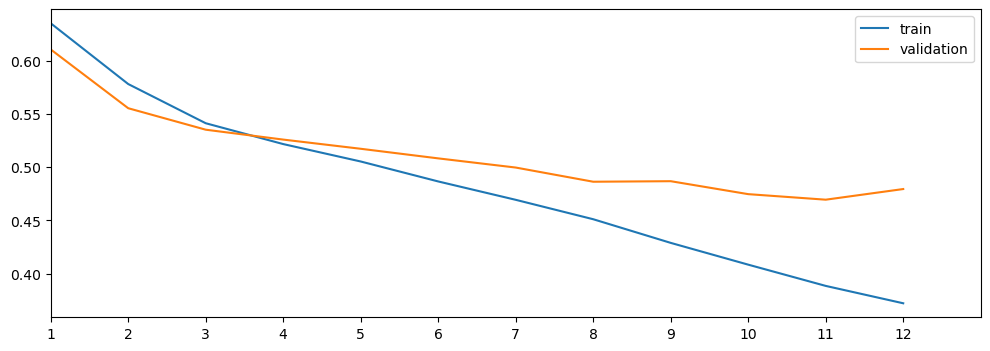

Epoch:12 Training Loss:0.37203594055268674 Validation Loss:0.47947449214530713 Accuracy: 0.79: 100%|██████████| 12/12 [10:41<00:00, 53.43s/it]              


In [6]:
## Se han ido probando diferentes hiperparámetros (lr, weight_decay y batchSize)
## El mejor resultado obtenido es con el batch = 64, lr = 0.0001 weight_decay = 0.001 (Validation Accuracy = 0.7857) 
# pero al hacer 50 epochs, se creaba overfitting (en la gráfica ComplexCNN_testBatchSize32_50epochs_lr0.0001_weightDecay0.001_0.7857.png se puede observar como a partir de epoch = 12, empieza a subir)
# Se hace lo mismo para 12 epochs y se guarda el resultado en ComplexCNN_testBatchSize64_12epochs_lr0.0001_weightDecay0.001_0.7805.pt
# Me tarda aprox 1 min por epoch
epochs = 12
lr =0.0001
model = ComplexCNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
trainloader = train_loader
valloader = val_loader

start = time.time()
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic

for epoch in pbar:
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    best_accuracy = 0
    model.train()

    for batch_idx, (data, target) in enumerate(trainloader, 1):
    
        data= data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    model.eval()
    
    targets = []
    predictions = []
    with torch.no_grad():
        for data, target in valloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
            loss = criterion(output, target)
            test_loss += loss.item()
            targets.extend(target.tolist())
            predictions.extend(torch.flatten(pred.cpu()).tolist())
        
    targets = np.asarray(targets)
    predictions = np.asarray(predictions)

    test_accuracy = accuracy_score(targets, predictions)
            
    
    train_loss /= len(trainloader)
    train_l[epoch - 1] = train_loss
    
    test_loss /= len(valloader)
    test_l[epoch - 1] = test_loss
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
    
    time_spent = time.time()-start
    print(f"Tiempo: {round(time_spent, 2)}")
    
    # VISUALITZACIO DINAMICA
    pl.figure(figsize=(12, 4))
    pl.plot(train_l[:epoch], label="train")
    pl.plot(test_l[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{test_loss} Accuracy: {test_accuracy}")

In [7]:
# Guardamos el mejor modelo
torch.save(best_model.state_dict(), f"models/ComplexCNN_testBatchSize64_{epochs}epochs_lr{lr}_weightDecay0.001_"+str(round(best_accuracy, 4))+".pt")

In [ ]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

In [ ]:

from sklearn.metrics import accuracy_score

model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        
        output= model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

In [10]:
##Carga del modelo y evaluación del accuracy

modelFinal = ComplexCNN().to(device)
modelFinal.load_state_dict(torch.load("models/ComplexCNN_testBatchSize64_12epochs_lr0.0001_weightDecay0.001_0.79.pt"))

modelFinal.eval()

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        
        output= modelFinal(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.79


In [ ]:
def generador(loader):
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        yield data, target

gen = generador(val_loader)

data, true_labels = next(gen)

model.eval()

output = model(data)

labels = output.detach().cpu().numpy()
images = data.cpu().numpy()
labels = np.argmax(labels, axis=1)

plt.title(f'Pred: {labels[0]} - True: {int(true_labels[0])}')
plt.imshow(images[0,0,:,:]);